# Introduction to Neural Network

It is based on Andrej's fantastic Youtube video [The spelled-out intro to neural networks and backpropagation: building `micrograd`](https://www.youtube.com/watch?v=VMj-3S1tku0).

It explains how deep neural network (DNN) works under the hood.

## Introduction

The library implements backpropagation algorithm that is used to efficiently 

- evaluate the gradient of 
- a loss function with respect to 
- the weights of 
- a neural network.

It improves the NN accuracy by iteratively tuning the weights of the neural network to minimize the loss function.

Backpropagation is the mathematical core of a DNN library like `PyTorch`.

Let's see a simple lib named [Micrograd](https://github.com/karpathy/micrograd).

### Backpropagation

A calculation can be expressed as a series of expressions. For example: 

```python
c = a + b
d = a + b * b ** 3
e = c - d
g = e ** 2
```

`g.backward()` is the backpropagation. It starts at `g`, goes backward through its expression graph and recursively applies the calculus chain rule to evaluate the partial derivative of `g` with respect to the all internal nodes (`e`, `d`, and `c`) and inputs (`a` and `b`). The derivatives are stores in the `.grad` attribute of each value.

A derivative tells how a value affects the expression result. It is the slope of growth of the value with regard to the result.

Though this made-up expression doesn't mean anything, it shows how deep neural network works. DNN are just mathematic expressions like this one.

### DNN

- A DNN is just a certain type of mathematic expression.
- The inputs for a DNN include input values and weights of DNN.
- The output of a DNN is prediction or a loss function.

For pedagogical reasons, Micrograd works on scalar values. A typical DNN works on multi-dimension data (called `tensor`s in PyTorch) for efficient parallel computation. They are fundamentally the same thing.

Micrograd has an engine `engine.py` that has less than 100 lines of Python code. The `nn.py` defines a DNN consists of `Neuron`, `Layer` and `MLP`. It only has 60 lines of Python code. 

That's enough to understand how DNN training works.

## The Engine Code

To run the demo code, please install Python libraries

```sh
pip install jupyter # for Jupyter Notebook
pip install numpy matplotlib pandas seaborn statsmodels # for computation and visualization
pip install graphviz # build expression graph
```

You also need to install `graphviz` application in your OS.
In MacOS, it might be `brew install graphviz`. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b
d.label = "d"
L = a + d
L.label = "L"
L

Value(data=-4.0)

In [4]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

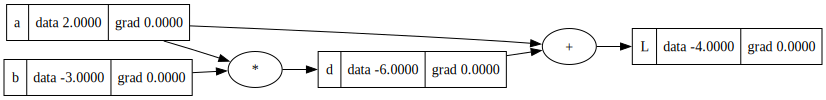

In [5]:
draw_dot(L)

## The Derivative Chain Rule

![img](../images/chain-rule.jpg)

The derivative of the composite function is the inner function ‍ within the derivative of the outer function, multiplied by the derivative of the inner function.

A [Wikipedia example](https://en.wikipedia.org/wiki/Chain_rule): 
> If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [6]:
def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [7]:
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

In [8]:
def __mul__(self, other):
    # to allow for scalar multiplication
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

    out._backward = _backward

    return out

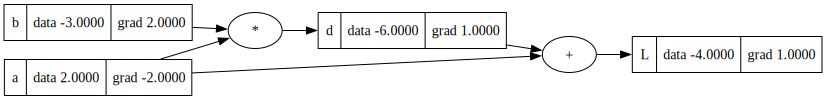

In [9]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b
d.label = "d"
L = a + d
L.label = "L"
L.backward()
draw_dot(L)

### A Neuron

A neuron is an expression with several inputs and one bias.
It creates one output.

For example: a partial neuron with two inputs can be expressed as 

`output = input_1 * weight_1 + input_2 * weight_2 + bias`

Weights and bias are **parameters**. 

It is partial because it misses a non-linear transformation - described later.

In [10]:
# a neuron with two inputs and one output
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(1.5, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1w1 = x1 * w1
# x2w2 = x2 * w2
# ws = x1w1 + x2w2
# o = ws + b

o = (x1 * w1 + x2 * w2) + b

print(f"output: {o.data:.4f}")
o.backward()

print("---")
print("w1 grad", w1.grad)
print("w2 grad", w2.grad)
print("b grad", b.grad)

output: 2.3814
---
w1 grad 2.0
w2 grad 1.5
b grad 1.0


### Computation Goal

If the computation goal is a loss function value that we want to minimize.
If the goal is to maximize a value, just change the adjustment direction,or negate the goal value to make it a minimization goal.

With `step_size` (learning rate), adjust parameters (weights and biases) because the inputs are given.

- Decrease a value's weight if its gradient is positive:
  - `v.weight -= step_size * v.gradient`
- Increase a value's weight if its gradient is negative:
  - `v.weight -= step_size * v.gradient`

In [11]:
step_rate = 0.01
w1.data -= step_rate * w1.grad
w2.data -= step_rate * w2.grad
b.data -= step_rate * b.grad

o = x1 * w1 + x2 * w2 + b

print(f"output: {o.data:.4f}")
print("---")
print("w1", w1)
print("w2", w2)
print("b", b)

output: 2.3089
---
w1 Value(data=-3.02)
w2 Value(data=0.985)
b Value(data=6.871373587019543)


## The PyTorch Library

PyTorch is a framework for building deep learning models.

The `Value` class uses the PyTorch API for its data element.

`pip3 install torch torchvision`

In [12]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([1.5]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b

print(n.data.item())
n.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

2.381373405456543
---
x2 1.0
w2 1.5
x1 -3.0
w1 2.0


## MLP: Multi-Layer Perceptron

![img](../images/mlp.png)

Source: https://www.pycodemates.com/2023/01/multi-layer-perceptron-a-complete-overview.html

### Weights and Bias

![img](../images/weights-and-bias.png)

![img](../images/formula.png)

Source: https://www.pycodemates.com/2023/01/multi-layer-perceptron-a-complete-overview.html

### Neuron (Finally)

The design of Neuron follows the PyTorch API based on a popular conceptual DNN model.

- A neuron has a number of inputs and a bias.
    - Each input `x` has a weight `w`. 
    - The input weights and the bias are **parameters**. 
    - All are initialized with random numbers.
- A neuron has one output that 
    - First, add the `bias` and the weighted sum of input: the `dot` product of `W` (all weights) and `X` (all inputs). The result is `z = WX + bias`.
    - Second, the sum is transformed by an activation function like `tanh` or `relu` (Rectified Linear Unit) to make it can handle complex non-linear relationships. Otherwise, the result is a simple linear transformation that is far from enough for real world knowledge.
    - The final output value is `tanh(WX + bias)` or `relu(WX + bias)`.

### Activation Function

In NN, activation function is used to transform input data to a desired one. Common activation functions include `Sigmoid`, `tanh` and `relu`. `relu` becomes popular due to its computational efficiency.

![img](../images/tanh.webp)

Source: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

###  `relu`

```python
# method of class Value
def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad

    out._backward = _backward
    return out
```

![img](../images/relu.png)
Source: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

In [13]:
import math


class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [14]:
import random


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # forward calculation of the neuron
    def __call__(self, x):
        # w * x + b. sum takes a start value. We start with b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [15]:
x = [2.0, 3.0]
neuron = Neuron(2)
print(neuron.parameters())
out = neuron(x)
print(out.data)
out.backward()
print(neuron.w[0].grad, neuron.w[1].grad, neuron.b.grad)
print(len(neuron.parameters()))

[Value(data=-0.17410571845800327), Value(data=0.09881122006455945), Value(data=0.6144128969853733)]
0.5099299657585559
1.479942860042956 2.219914290064434 0.739971430021478
3


### Layer

- A `Layer` has a number of `Neuron`s, each `Neuron` is fully connected to all inputs.
- Each `Neuron` evaluates its inputs independently.
- It has a number of output is the number of neurons because each neuron has one output.

How many parameters do we have?

In [16]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [17]:
x = [2.0, 3.0]
layer = Layer(2, 3)
out = layer(x)
print(out)
print(len(layer.parameters()))

[Value(data=-0.9991496548074624), Value(data=-0.8907805594432361), Value(data=0.36255704890633006)]
9


### MLP

A MLP has many layers that whose inputs and outputs are connected between two layers.

How many parameters do we have?

In [18]:
class MLP:
    # nin is the number of input neurons
    # nouts is a list of number of neurons in each layer
    def __init__(self, nin, nouts):
        layer_sizes = [nin] + nouts
        layer_range = range(len(nouts))
        self.layers = [Layer(layer_sizes[i], layer_sizes[i + 1]) for i in layer_range]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
x = [2.0, 3.0]
model = MLP(2, [4, 4, 1])
out = model(x)
print(out.data)
print(len(model.parameters()))

0.2300912393555668
37


## Model Training

A NN is initialized with random parameters (weights and biases) when it is created.
Then feed it with inputs and desired targets, based on the difference (a loss value) between its outputs (predicted values) and the desired targets, tune its parameters to minimize the loss value.

For example, a batch usually have multiple inputs, first run forward pass:

- for input `[1.61370966, -0.1246459]`, the output should be `1` (might mean `YES`/`On`/`High`...)
- for input `[1.12211461,  0.08147717]`, the output should be `-1` (might mean `No`/`Off`/`Low`...)
- ... 

Then, calculate the total loss of each batch, ran `loss.backward()` (the backward pass) to tune the parameters to minimize loss. 

In [20]:
np.random.seed(1337)
random.seed(1337)

model = MLP(2, [4, 4, 1])

# forward pass
xs = [
    [2.0, 3.0],
    [3.0, -1.0],
    [0.5, 1.0],
    [1.0, 1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

scores = [model(x) for x in xs]
losses = [(1 + -y * score).relu() for y, score in zip(ys, scores)]
loss = sum(losses) / len(losses)

# also get accuracy
accuracies = [(y > 0) == (score.data > 0) for y, score in zip(ys, scores)]
accuracy = sum(accuracies) / len(accuracies)

print(ys, "prediction: ", [f"{score.data:.2f}" for score in scores])
print(f"Loss: {loss.data:.4f}, Accuracy: {accuracy * 100:.2f}%")

[1.0, -1.0, -1.0, 1.0] prediction:  ['-0.51', '-0.80', '-0.66', '-0.69']
Loss: 0.9371, Accuracy: 50.00%


## Demo: Training and Visualization

[`scikit-datasets`](https://github.com/daviddiazvico/scikit-datasets) has some training datasets for machine learning projects.

Use `pip install scikit-datasets` to install the datasets.

In [21]:
from sklearn.datasets import make_moons

np.random.seed(1337)
random.seed(1337)

xs, ys = make_moons(n_samples=100, noise=0.1)
ys = 2 * ys - 1  # convert 0 to -1, and keep 1 as 1

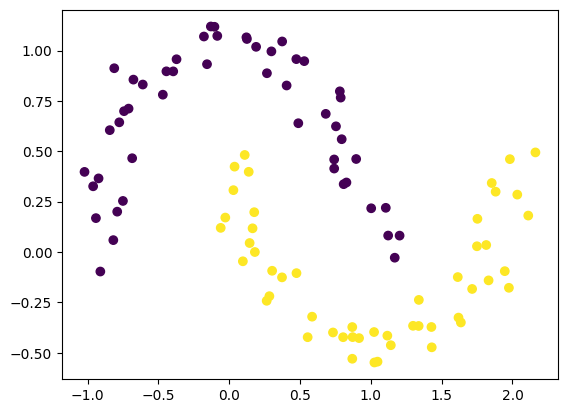

In [22]:
plt.scatter(xs[:, 0], xs[:, 1], c=ys)

### Define a `loss` Function

Define a `loss` function to measure the difference between predicted and the target. It is the optimization goal that is to be minimized. There are many loss functions.

In [23]:
def calc_loss():

    scores = [model(x) for x in xs]

    # svm "max-margin" loss
    losses = [(1 + -y * score).relu() for y, score in zip(ys, scores)]
    loss = sum(losses) / len(losses)

    # also get accuracy
    accuracy = [(y > 0) == (score.data > 0) for y, score in zip(ys, scores)]
    return loss, sum(accuracy) / len(accuracy)

### Tuning Parameter

Staring from the `loss`, use backpropagation to calculate gradients.

Don't forget resetting gradients to zero !! But why?

Then adjust parameters to minimize the target.

In [24]:
model = MLP(2, [16, 16, 1])

iterations = 51
for iteration in range(iterations):

    # backward pass, don't forget resetting gradients to zero !!
    loss, accuracy = calc_loss()

    for parameter in model.parameters():
        parameter.grad = 0.0

    loss.backward()

    # update
    learning_rate = 1.0 - 0.9 * iteration / iterations
    for parameter in model.parameters():
        parameter.data -= learning_rate * parameter.grad

    if iteration % 10 == 0:
        print(f"step {iteration} loss {loss.data:.4f}, accuracy {accuracy*100:.2f}%")

step 0 loss 0.7733, accuracy 68.00%
step 10 loss 0.2067, accuracy 91.00%
step 20 loss 0.1276, accuracy 96.00%
step 30 loss 0.0835, accuracy 99.00%
step 40 loss 0.0605, accuracy 100.00%
step 50 loss 0.0522, accuracy 100.00%


In [25]:
model([-1, -0.25]), model([2.0, 0.5])

(Value(data=-0.8329521424502776), Value(data=0.8502412892018412))

(-1.548639298268643, 1.951360701731357)

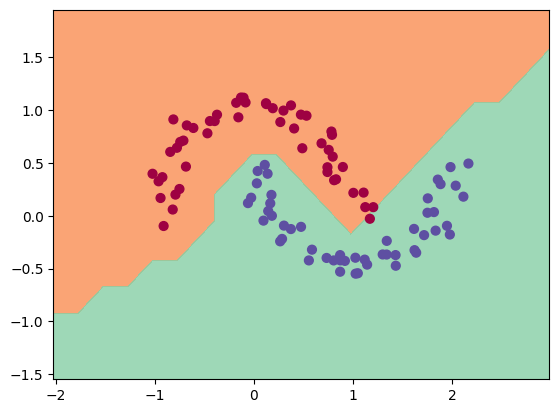

In [26]:
h = 0.25
x_min, x_max = xs[:, 0].min() - 1, xs[:, 0].max() + 1
y_min, y_max = xs[:, 1].min() - 1, xs[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = [model(x) for x in Xmesh]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(xs[:, 0], xs[:, 1], c=ys, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Summary

- A neural network is a set of mathematical expression - represented as MLP.
- It takes inputs and has weights/bias as its parameters.
- Repeat the following steps until the prediction is good enough.
    - The forward pass calculates prediction values.
    - The loss function measures the accuracy of the prediction. The lower the loss value, the better the prediction result.
    - The backward (backpropagation) of the loss calculates the gradients of its neurons.
    - Adjust parameters based on their gradients to decrease the loss value. The step size (learning rate) determines the amount the changes.